## Exponential Duration Model
---


In [1]:
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
from IPython.display import display

The following cell generate data from

\begin{align*}
 & p(y_{i}|x_{1i},x_{2i}) = \frac1{\theta_{i}}e^{-\frac{y_{i}}{\theta_{i}}},\quad y_{i} > 0,\\
 & \theta_{i} =  \exp(0.5 x_{1i} - 0.5 x_{2i}),\quad i=1,\dots,500.
\end{align*}


In [2]:
n = 500
np.random.seed(99)
x1 = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n)
x2 = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n)
the = np.exp(0.5*x1 - 0.5*x2)
y = st.expon.rvs(scale=the)
X = np.stack((np.ones(n), x1, x2), axis=1)

In [3]:
n, k = X.shape
b0 = np.zeros(k)
A0 = 0.01 * np.eye(k)
exponential_duration_model = pm.Model()
with exponential_duration_model:
    b = pm.MvNormal('b', mu=b0, tau=A0, shape=k)
    idx = pm.math.dot(X, b)
    likelihood = pm.Exponential('y', lam=pm.math.exp(-idx), observed=y)

In [4]:
n_draws = 5000
n_chains = 4
n_tune = 1000
with exponential_duration_model:
    trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, random_seed=123)
results = pm.summary(trace, hdi_prob=0.95)
var_names = ['$\\beta_{:d}$'.format(index) for index in range(k)]
results.index = var_names
sim_param = dict([(var, trace.posterior['b'].values[:, :, index]) for index, var in enumerate(var_names)])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2 seconds.


In [5]:
display(results)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
$\beta_0$,0.012,0.045,-0.074,0.102,0.0,0.0,29181.0,15485.0,1.0
$\beta_1$,0.522,0.043,0.439,0.609,0.0,0.0,31110.0,16119.0,1.0
$\beta_2$,-0.562,0.046,-0.650,-0.470,0.0,0.0,31270.0,15685.0,1.0


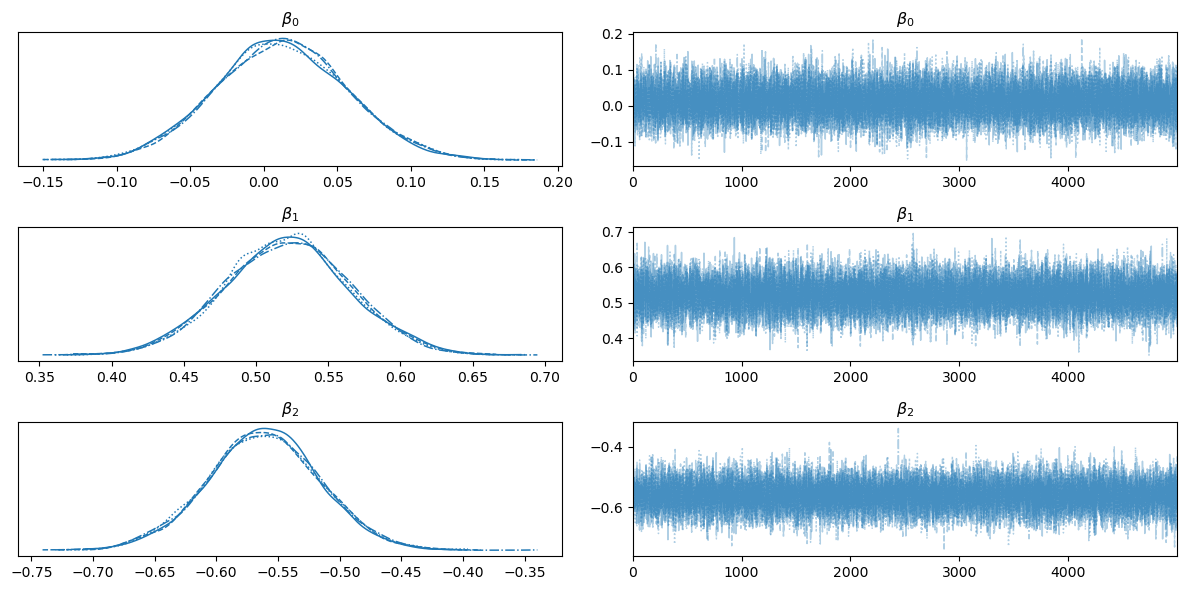

In [6]:
pm.plot_trace(sim_param)
plt.tight_layout()
plt.show()

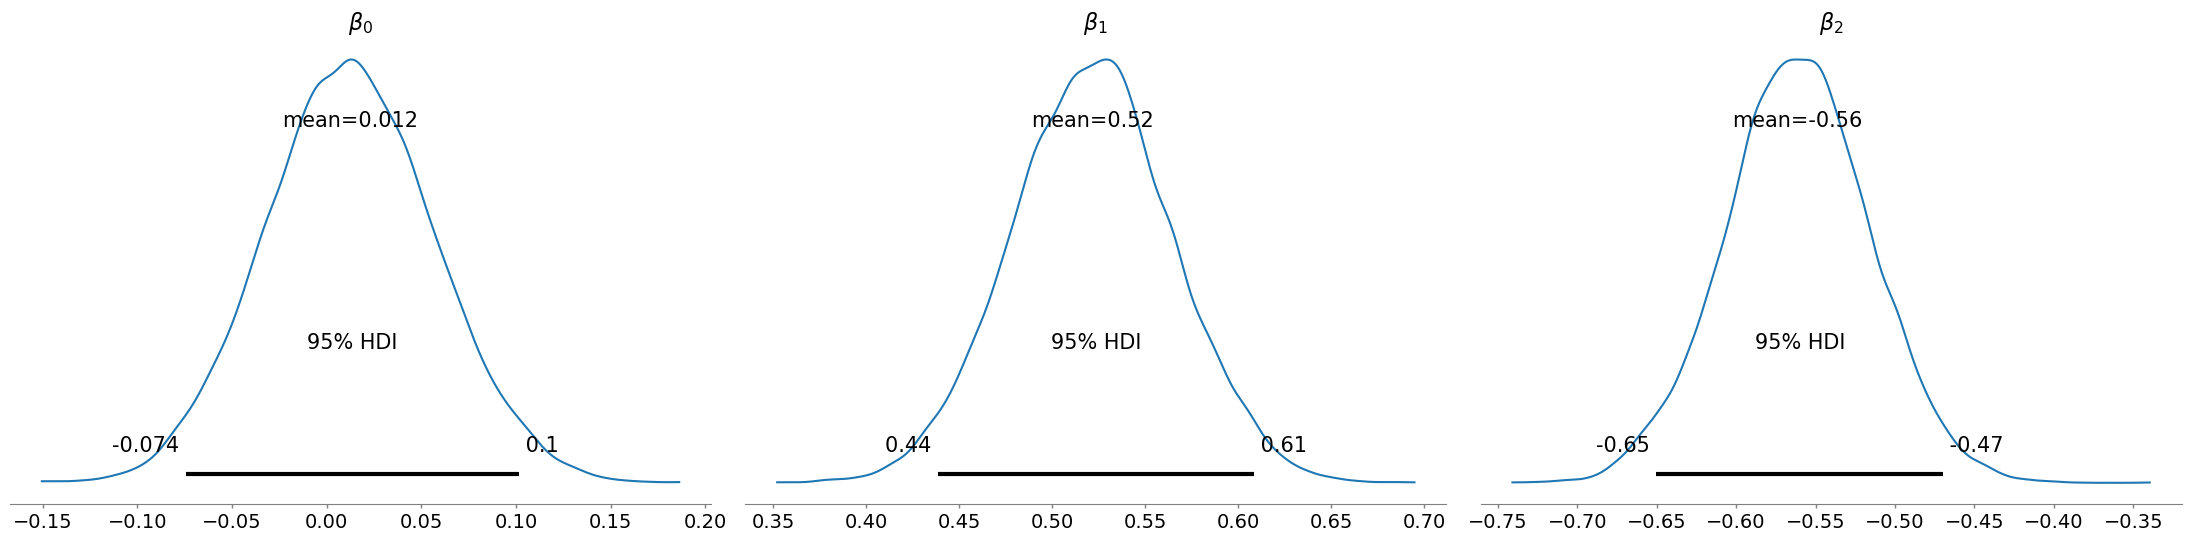

In [7]:
pm.plot_posterior(sim_param, kind='kde', point_estimate='mean', hdi_prob=0.95)
plt.tight_layout()
plt.show()